In [ ]:
import h5py
from io import BytesIO
import imageio.v3 as iio
from matplotlib import pyplot as plt
from geovision.data.inria import Inria, Inria_Building_Segmentation_HDF5
#Inria.transform(src = "staging/imagefolder", to = "hdf5", tile_size = 256, tile_stride = 256)
#from geovision.data import DatasetConfig

(256, 256, 3)


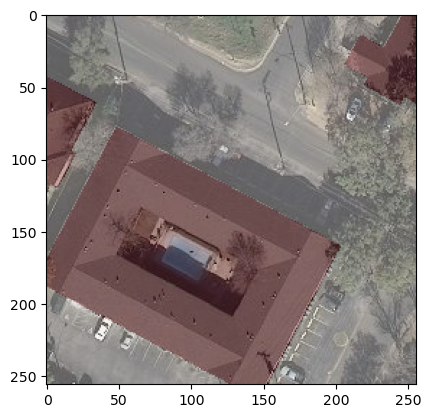

In [8]:
with h5py.File(Inria.local / "hdf5" / "inria_jpeg.h5") as f:
    idx = 24
    image = iio.imread(BytesIO(f["sup/images"][idx]))
    mask = iio.imread(BytesIO(f["sup/masks"][idx]))

print(image.shape)

fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(mask, alpha = 0.3, cmap = "Reds")

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.windows import Window
import shapely
import imageio.v3 as iio
import matplotlib.pyplot as plt
import skimage
from pprint import pprint 

import sys; sys.path.append("../") if "../" not in sys.path else None

In [ ]:
DATA = Path.home() / "datasets" / "urban_footprint" 
SCENE = "austin1.tif"
IMAGE_PATH = DATA / "sup" / "images" / SCENE 
MASK_PATH = DATA / "sup" / "masks" / SCENE 

In [ ]:
tile_dims = Window(2500, 2500, 500, 500)

with rio.open(IMAGE_PATH) as src_image:
    with rio.open(MASK_PATH) as src_mask:
        image = src_image.read(window = tile_dims)
        mask = src_mask.read(window = tile_dims).squeeze()
        transform = rio.windows.transform(tile_dims, src_mask.transform)
        crs = src_mask.crs
        # print(crs)
        # print(transform)


contours = skimage.measure.find_contours(mask)
#contours = [skimage.measure.approximate_polygon(c, .4) for c in contours]
transform_matrix = np.array(transform).reshape(3, 3)

polygons = list()
for vertices in contours:
    vertices = np.matrix(vertices) # vertices = [[y1, x1], [y2, x2], ..., [yn, xn]], shape = (#vertices, 2)
    vertices[:, [0, 1]] = vertices[:, [1, 0]] # vertices = [[x1, y1], [x2, y2], ..., [xn, yn]], shape = (#vertices, 2)
    vertices = np.c_[vertices, np.ones(vertices.shape[0])] # vertices = [[x1, y1, 1], [x2, y2, 1], ..., [xn, yn, 1]], shape = (#vertices, 3)
    vertices = np.transpose(vertices) # shape = (3, #vertices)
    vertices = np.matmul(transform_matrix, vertices) # shape = (3, #vertices)
    vertices = np.transpose(vertices[:2]) # shape = (#vertices, 2)
    polygons.append(shapely.Polygon(vertices))

footprints_gdf = gpd.GeoDataFrame(geometry=polygons, crs = crs).simplify(.5)

fig, (l, r) = plt.subplots(1, 2, figsize = (10, 10))
l.imshow(image.transpose(1, 2, 0))
l.imshow(mask, cmap = "Reds", alpha = .5)
footprints_gdf.plot(ax = r)

footprints_gdf.to_file(Path.home() / "experiments" / "urban_footprint_segmentation" / "test.geojson", driver = "GeoJSON")

In [ ]:
import folium
footprints_gdf = footprints_gdf.to_crs(epsg=4326)
map = folium.Map(location = (30.264048,-97.750112), zoom_start=13)
for _, row in footprints_gdf.iterrows():
    footprint = gpd.GeoSeries(row["geometry"])#.simplify(0.001)
    footprint = footprint.to_json()
    footprint = folium.GeoJson(data = footprint, style_function = lambda x: {"fillColor": "red"})
    footprint.add_to(map)
map